<a href="https://colab.research.google.com/github/solanaf/PSEN1-FAD-TF-Targets/blob/main/ATAC_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Install R Packages/Libraries

In [ ]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("edgeR")
BiocManager::install("GenomicFeatures")
BiocManager::install(c("ChIPseeker", "TxDb.Hsapiens.UCSC.hg38.knownGene", "org.Hs.eg.db"))
BiocManager::install("chipenrich")
BiocManager::install("rtracklayer",force=TRUE)
BiocManager::install("plyranges")

library(edgeR)
library(GenomicFeatures)
library(ChIPseeker)
library(TxDb.Hsapiens.UCSC.hg38.knownGene)
library(org.Hs.eg.db)
library(chipenrich)
library(ggplot2)
library(rtracklayer) # for BED file conversion

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.20 (BiocManager 1.30.25), R 4.4.3 (2025-02-28)

Installing package(s) 'GenomicFeatures'

also installing the dependencies ‘lambda.r’, ‘matrixStats’, ‘abind’, ‘SparseArray’, ‘futile.logger’, ‘BH’, ‘MatrixGenerics’, ‘S4Arrays’, ‘DelayedArray’, ‘plogr’, ‘png’, ‘bitops’, ‘BiocParallel’, ‘Rhtslib’, ‘SummarizedExperiment’, ‘RCurl’, ‘rjson’, ‘UCSC.utils’, ‘GenomeInfoDbData’, ‘Biobase’, ‘RSQLite’, ‘KEGGREST’, ‘zlibbioc’, ‘XML’, ‘Rsamtools’, ‘GenomicAlignments’, ‘BiocIO’, ‘restfulr’, ‘BiocGenerics’, ‘S4Vectors’, ‘IRanges’, ‘GenomeInfoDb’, ‘GenomicRanges’, ‘AnnotationDbi’, ‘XVector’, ‘Biostrings’, ‘rtracklayer’


Old packages: 'xml2'

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement reposito

# 1. Differential Peak Analysis (edgeR)

### 1.1 Import counts, reorganize etc.

In [ ]:
counts <- read.delim("GSE206588_Subramaniam.PSEN1.ATACcounts.tsv", header=TRUE)
head(counts)

# Keep only numeric count data
count_data <- counts[,6:ncol(counts)]

# Explicitly assign row names before DGEList
rownames(count_data) <- paste(counts$seqnames, counts$start, counts$end, sep=":")

# Define condition groups (WT vs. FAD)
#group <- factor(c("WT", "WT", "WT", "FAD", "FAD", "FAD"))
group <- factor(c("WT", "WT", "WT", "FAD", "FAD", "FAD"), levels = c("WT", "FAD"))

# Create a DGEList object
dge <- DGEList(counts = count_data, group = group)

# Reassign row names to ensure they persist
rownames(dge$counts) <- rownames(count_data)

# Check the first few row names
head(rownames(dge$counts))

dge

,seqnames,start,end,width,strand,X27_4.NDC1.1_ATAC_S1,X27_4.NDC1.2_ATAC_S2,X27_4.NDC1.3_ATAC_S3,F12424_4.A79V.1_ATAC_S22,F12424_4.A79V.2_ATAC_S23,F12424_4.A79V.3_ATAC_S24
,<chr>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr1,9930,10620,691,*,415.98146,304.86383,379.92792,198.46291,188.05771,154.15622
2,chr1,28680,29480,801,*,10.62080,29.35726,11.95577,25.33569,31.82515,21.51017
3,chr1,180690,181910,1221,*,217.72647,135.49504,134.17035,96.06450,62.20370,60.22848
4,chr1,190660,191740,1081,*,51.33388,56.45626,74.39148,38.00354,30.37855,35.13328
5,chr1,777686,779575,1890,*,479.70628,461.81225,486.20147,362.08925,383.34841,385.74906
6,chr1,819166,823905,4740,*,69.03522,74.52227,87.67567,97.12015,37.61154,54.49243


[1] "chr1:9930:10620"    "chr1:28680:29480"   "chr1:180690:181910"
[4] "chr1:190660:191740" "chr1:777686:779575" "chr1:819166:823905"

,X27_4.NDC1.1_ATAC_S1,X27_4.NDC1.2_ATAC_S2,X27_4.NDC1.3_ATAC_S3,F12424_4.A79V.1_ATAC_S22,F12424_4.A79V.2_ATAC_S23,F12424_4.A79V.3_ATAC_S24
chr1:9930:10620,415.981463,304.86383,379.92792,198.46291,188.05771,154.15622
chr1:28680:29480,10.620803,29.35726,11.95577,25.33569,31.82515,21.51017
chr1:180690:181910,217.726468,135.49504,134.17035,96.06450,62.20370,60.22848
chr1:190660:191740,51.333883,56.45626,74.39148,38.00354,30.37855,35.13328
chr1:777686:779575,479.706283,461.81225,486.20147,362.08925,383.34841,385.74906
chr1:819166:823905,69.035222,74.52227,87.67567,97.12015,37.61154,54.49243
chr1:826176:828326,192.944594,190.82218,200.59132,187.90638,168.52864,181.40244
chr1:869615:870295,7.080536,18.06600,13.28419,41.17050,44.12123,28.68023
chr1:903526:906046,134.530175,120.81641,132.84193,289.24914,223.49936,266.00911
chr1:919545:926455,430.142535,396.32298,514.09827,609.11224,486.78015,481.82782


### 1.2 Filter, normalize etc

In [ ]:
# Filter peaks: Keep peaks with counts per million (CPM) > 1 in at least 3 samples
keep <- rowSums(cpm(dge) > 1) >= 3
dge_filtered <- dge[keep, , keep.lib.sizes=FALSE]

# Check how many peaks are retained
dim(dge_filtered)

# Normalize using the TMM (trimmed mean of M-values) method
dge_filtered <- calcNormFactors(dge_filtered, method = "TMM")

# Check normalization factors
dge_filtered$samples

[1] 53540     6

,group,lib.size,norm.factors
,<fct>,<dbl>,<dbl>
X27_4.NDC1.1_ATAC_S1,WT,10691658,0.9575447
X27_4.NDC1.2_ATAC_S2,WT,10333821,0.9812631
X27_4.NDC1.3_ATAC_S3,WT,10532281,0.9671136
F12424_4.A79V.1_ATAC_S22,FAD,9625680,1.0281095
F12424_4.A79V.2_ATAC_S23,FAD,9669252,1.0275846
F12424_4.A79V.3_ATAC_S24,FAD,9481876,1.0416481


### 1.3 Estimate & Plot Dispersion
Biological Coefficient of Variation (BCV) plot looks great! Here’s what it means:

X-axis (Average log CPM): Represents average expression levels (log counts per million). Y-axis (BCV values): Represents biological variation across samples. Black dots: Individual peaks with their estimated tagwise dispersions. \
\
**Red line:** Common dispersion estimate. \
**Blue line:** Trend dispersion across expression levels. \
\
**Interpretation:** \
Lowly expressed peaks (left side) tend to have higher variance, which is normal. Well-expressed peaks (right side) have lower variance, as expected. The trend line follows a smooth distribution, indicating a good fit.

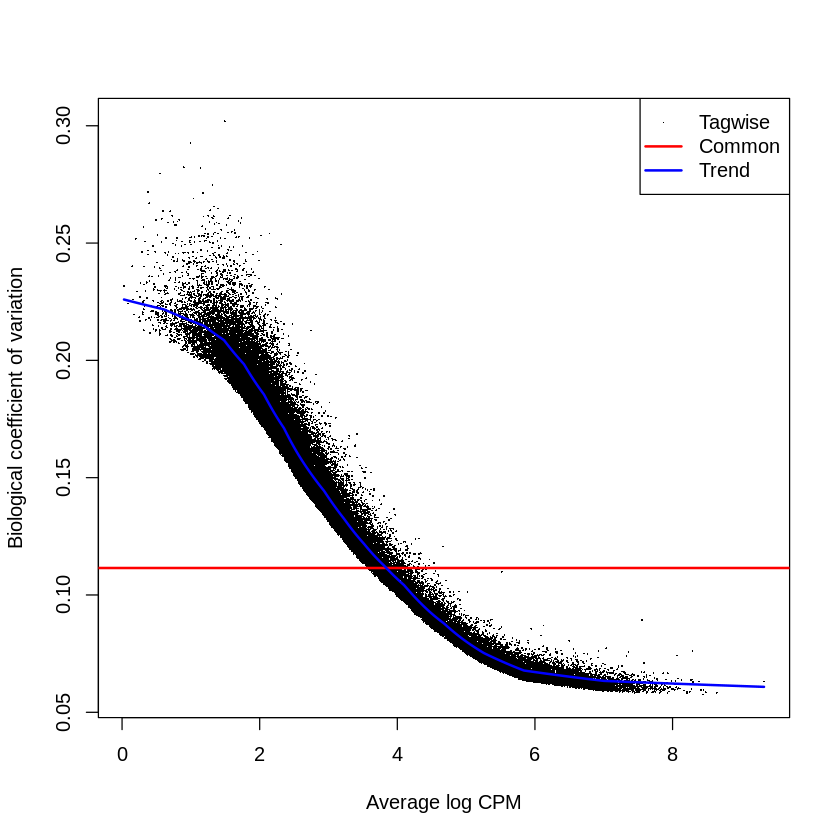

In [ ]:
# Estimate common dispersion
design <- model.matrix(~group)
dge_filtered <- estimateDisp(dge_filtered, design)

# Check dispersion estimates
plotBCV(dge_filtered)

### 1.4 Fit Data & Volcano Plot
Understanding the Results Table Column Meaning logFC Log fold-change (positive = more accessible in FAD, negative = more accessible in WT) logCPM Log counts per million (expression level of the peak) F F-statistic from the quasi-likelihood test (higher = more significant) PValue Raw p-value (lower = more significant) FDR False discovery rate (adjusted p-value, typically < 0.05 is significant)

Top peaks (rows with lowest FDR) are the most differentially accessible regions. Negative logFC means peaks are more accessible in WT, while positive logFC means more accessible in FAD. FDR values are very low (~e-31 to e-41), meaning the results are statistically significant.

Warning message in makeContrasts(groupFAD, levels = design):
“Renaming (Intercept) to Intercept”


,logFC,logCPM,F,PValue,FDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr10:38401430:38404060,-5.589130,5.467563,1257.1655,5.250132e-46,2.810921e-41
chr2:113602030:113605150,-4.047306,5.790065,1130.5331,1.657812e-44,4.437963e-40
chr3:147391180:147399460,2.530250,6.307139,780.1700,2.502399e-39,4.465949e-35
chr3:147403370:147425200,2.096089,7.016508,761.4542,5.402025e-39,7.230611e-35
chr6:26042920:26046350,-5.125411,4.721416,716.9442,3.682483e-38,3.943203e-34
chr10:122878840:122880540,-5.731527,4.396849,618.7627,3.828793e-36,3.416560e-32
chr12:130714170:130717280,-4.212101,4.591906,574.3871,3.651097e-35,2.792568e-31
chr12:128822630:128824980,-4.796253,4.459929,568.7415,4.999664e-35,3.346025e-31
chr5:3180864:3183584,-3.387194,4.993487,564.7790,6.121753e-35,3.457363e-31


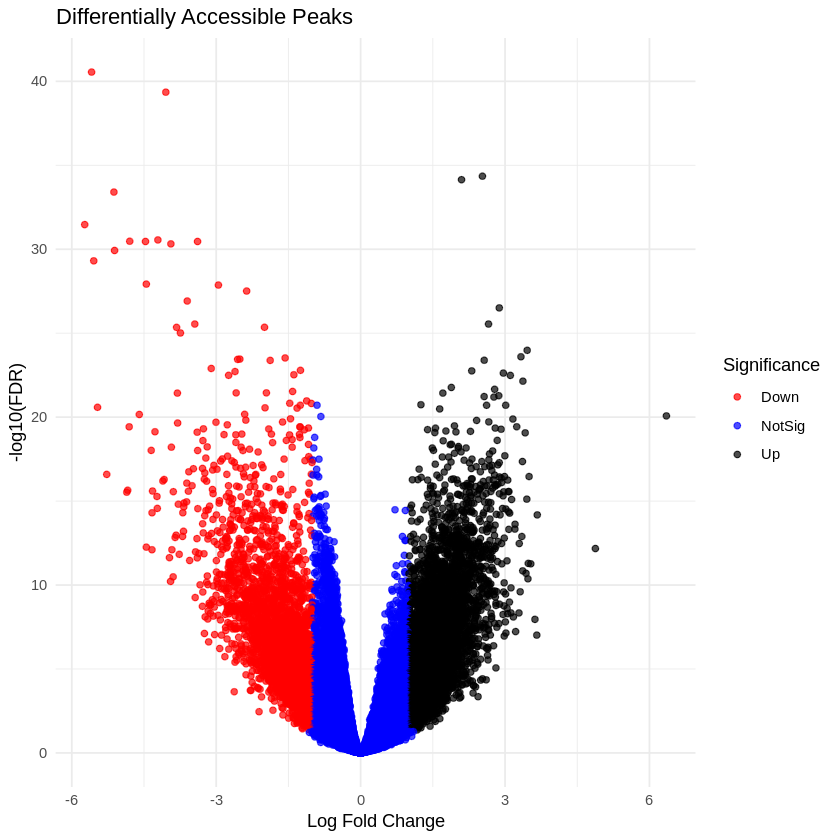

In [ ]:
# Fit the negative binomial generalized log-linear model
fit <- glmQLFit(dge_filtered, design)

# Test for differential accessibility
contrast_matrix <- makeContrasts(groupFAD, levels = design)
qlf <- glmQLFTest(fit, contrast=contrast_matrix)

# View top differentially accessible regions
topTags(qlf)

# Save progress
write.csv(topTags(qlf, n=Inf), "ATAC_edgeR_results.csv", row.names=TRUE)

# Prepare results for plotting
res <- as.data.frame(topTags(qlf, n=Inf))
res$Significance <- ifelse(res$FDR < 0.05 & abs(res$logFC) > 1,
                           ifelse(res$logFC > 0, "Up", "Down"), "NotSig")

# Create volcano plot
ggplot(res, aes(x=logFC, y=-log10(FDR), color=Significance)) +
  geom_point(alpha=0.7) +
  scale_color_manual(values=c("red", "blue", "black")) +
  theme_minimal() +
  labs(title="Differentially Accessible Peaks",
       x="Log Fold Change", y="-log10(FDR)")

# # Save (not sure we need this? what is top_peaks)
# write.csv(top_peaks, file="ATAC_Top_DARs.csv", row.names=TRUE)
# file.exists("ATAC_Top_DARs.csv")  # Should return TRUE if saved correctly

# nrow(top_peaks)
# summary(res$FDR)  # See if any FDR values are < 0.05
# summary(abs(res$logFC))  # See if logFC > 1 exists


# 2. Annotation (ChIPseeker)

In [ ]:
# Read the ATAC-seq peak file
atac_peaks <- read.csv("ATAC_edgeR_results.csv", row.names=1)

# Extract row names and split into chromosome, start, and end
peak_info <- do.call(rbind, strsplit(rownames(atac_peaks), "[:-]"))
colnames(peak_info) <- c("chr", "start", "end")

# Convert to numeric
peak_info <- data.frame(chr = peak_info[,1],
                        start = as.numeric(peak_info[,2]),
                        end = as.numeric(peak_info[,3]))

# Convert to GRanges object
gr_peaks <- GRanges(seqnames = peak_info$chr,
                    ranges = IRanges(start = peak_info$start, end = peak_info$end))

# Check output
head(gr_peaks)

GRanges object with 6 ranges and 0 metadata columns:
      seqnames              ranges strand
         <Rle>           <IRanges>  <Rle>
  [1]    chr10   38401430-38404060      *
  [2]     chr2 113602030-113605150      *
  [3]     chr3 147391180-147399460      *
  [4]     chr3 147403370-147425200      *
  [5]     chr6   26042920-26046350      *
  [6]    chr10 122878840-122880540      *
  -------
  seqinfo: 22 sequences from an unspecified genome; no seqlengths

In [ ]:
# Load the hg38 gene annotation database
txdb <- TxDb.Hsapiens.UCSC.hg38.knownGene

# Annotate peaks
peak_anno <- annotatePeak(gr_peaks, TxDb=txdb, annoDb="org.Hs.eg.db")

# View annotated peaks
head(as.data.frame(peak_anno))

>> preparing features information...		 2025-03-15 04:19:44 AM 
>> identifying nearest features...		 2025-03-15 04:19:48 AM 
>> calculating distance from peak to TSS...	 2025-03-15 04:19:51 AM 
>> assigning genomic annotation...		 2025-03-15 04:19:51 AM 
>> adding gene annotation...			 2025-03-15 04:20:44 AM 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2025-03-15 04:20:45 AM 
>> done...					 2025-03-15 04:20:45 AM 


,seqnames,start,end,width,strand,annotation,geneChr,geneStart,geneEnd,geneLength,geneStrand,geneId,transcriptId,distanceToTSS,ENSEMBL,SYMBOL,GENENAME
,<fct>,<int>,<int>,<int>,<fct>,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
1,chr10,38401430,38404060,2631,*,Promoter (<=1kb),10,38383023,38402856,19834,2,285961,ENST00000475691.6,0,ENSG00000291056,SEPTIN7P9,septin 7 pseudogene 9
2,chr2,113602030,113605150,3121,*,Promoter (<=1kb),2,113599036,113601261,2226,2,84771,ENST00000437401.1,-769,ENSG00000290825,DDX11L2,DEAD/H-box helicase 11 like 2 (pseudogene)
3,chr3,147391180,147399460,8281,*,Promoter (<=1kb),3,147393422,147507986,114565,1,440982,ENST00000472523.1,0,NA,LOC440982,uncharacterized LOC440982
4,chr3,147403370,147425200,21831,*,Promoter (<=1kb),3,147421327,147510293,88967,1,440982,ENST00000474034.1,0,NA,LOC440982,uncharacterized LOC440982
5,chr6,26042920,26046350,3431,*,Promoter (<=1kb),6,26043227,26043713,487,2,3018,ENST00000615966.2,0,ENSG00000276410,H2BC3,H2B clustered histone 3
6,chr10,122878840,122880540,1701,*,Promoter (<=1kb),10,122832185,122879583,47399,2,100533195,ENST00000650744.1,0,ENSG00000286088,FAM24B-CUZD1,FAM24B-CUZD1 readthrough


In [ ]:
# Convert to data frame
peak_anno_df <- as.data.frame(peak_anno)

# Save annotated peaks
write.csv(peak_anno_df, "ATAC_Annotated_Peaks.csv", row.names=FALSE)

# Save as BED file
gr_peaks <- GenomicRanges::makeGRangesFromDataFrame(peak_anno_df)
# peaks_gr <- GRanges(
#   seqnames = annotated_peaks$seqnames,
#   ranges = IRanges(start = annotated_peaks$start, end = annotated_peaks$end),
# )
export.bed(gr_peaks, "atacpeaks.bed")

# 3. Peak Enrichment (Polyenrich)

In [ ]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("chipenrich")
library(chipenrich)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.20 (BiocManager 1.30.25), R 4.4.3 (2025-02-28)

Installing package(s) 'BiocVersion', 'chipenrich'

also installing the dependencies ‘formatR’, ‘lambda.r’, ‘futile.options’, ‘matrixStats’, ‘abind’, ‘SparseArray’, ‘zoo’, ‘futile.logger’, ‘snow’, ‘BH’, ‘MatrixGenerics’, ‘S4Arrays’, ‘DelayedArray’, ‘plogr’, ‘deldir’, ‘RcppEigen’, ‘gridExtra’, ‘viridis’, ‘Formula’, ‘MatrixModels’, ‘mvtnorm’, ‘TH.data’, ‘sandwich’, ‘checkmate’, ‘bitops’, ‘BiocParallel’, ‘Rhtslib’, ‘SummarizedExperiment’, ‘RCurl’, ‘rjson’, ‘Biobase’, ‘RSQLite’, ‘KEGGREST’, ‘UCSC.utils’, ‘GenomeInfoDbData’, ‘XVector’, ‘png’, ‘jpeg’, ‘interp’, ‘Hmisc’, ‘quantreg’, ‘SparseM’, ‘polspline’, ‘multcomp’, ‘htmlTable’, ‘XML’, ‘Biostrings’, ‘

In [ ]:
gr_peaks <- as.data.frame(read.table("gimme_input_integrated.bed",header = FALSE, sep="\t",stringsAsFactors=FALSE))

In [ ]:
colnames(gr_peaks) <- c("chr", "start", "end")


In [ ]:
gr_peaks

chr,start,end
<chr>,<int>,<int>
chr7,137354220,137356010
chr5,151683480,151688570
chr15,37220170,37223780
chr5,90597811,90598971
chr14,100824900,100828880
chr4,87525390,87529900
chr6,122778210,122781510
chr7,121796280,121800110
chr2,216620690,216622390


In [ ]:
# Run chipenrich/polyenrich
results <- polyenrich(peaks = gr_peaks,
                      genome = "hg38",
                      genesets = "GOBP",
                      locusdef = "nearest_tss",
                      qc_plots = FALSE,
                      out_name = NULL,
                      n_cores = 1)

# View first few results
head(results$results)

# Save results
write.csv(results$results, "ATAC_ChipEnrich_Results.csv", row.names=FALSE)

Reading peaks from data.frame...

Assigning peaks to genes with assign_peaks(...) ..

Test: Poly-Enrich

Genesets: Gene Ontology Biological Process

Running tests..



,Geneset.Type,Geneset.ID,Description,P.value,FDR,Effect,Odds.Ratio,Status,N.Geneset.Genes,N.Geneset.Peak.Genes,Geneset.Avg.Gene.Length,Geneset.Peak.Genes
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<int>,<dbl>,<chr>
1,Gene Ontology Biological Process,GO:0009888,tissue development,3.123654e-16,1.740188e-12,0.5092830,1.664098,enriched,1981,351,160137.2,"1021, 2246, 3624, 3670, 3975, 4781, 7431, 29887, 59, 88, 100, 148, 230, 301, 309, 389, 429, 595, 613, 631, 651, 652, 653, 655, 658, 677, 793, 839, 844, 847, 857, 860, 871, 873, 960, 977, 983, 1030, 1063, 1278, 1281, 1284, 1289, 1290, 1295, 1301, 1303, 1310, 1373, 1435, 1465, 1466, 1512, 1545, 1749, 1750, 1829, 1909, 1950, 1956, 1958, 1959, 1969, 2006, 2012, 2013, 2042, 2047, 2125, 2138, 2201, 2202, 2260, 2261, 2263, 2353, 2487, 2625, 2637, 2668, 2697, 2736, 2737, 2908, 2947, 3037, 3164, 3175, 3280, 3299, 3371, 3399, 3479, 3488, 3642, 3643, 3655, 3685, 3688, 3690, 3691, 3693, 3696, 3725, 3726, 3908, 3911, 3913, 3955, 3958, 4036, 4038, 4048, 4072, 4088, 4091, 4192, 4208, 4232, 4233, 4254, 4255, 4256, 4313, 4524, 4638, 4643, 4760, 4776, 4825, 4851, 4852, 4853, 4867, 4878, 4902, 4917, 4919, 5079, 5080, 5106, 5155, 5156, 5159, 5239, 5293, 5308, 5314, 5396, 5420, 5459, 5593, 5618, 5764, 5872, 5915, 5920, 6239, 6258, 6386, 6423, 6492, 6496, 6497, 6608, 6615, 6660, 6696, 6772, 6781, 6876, 6934, 6935, 7020, 7041, 7042, 7043, 7045, 7048, 7062, 7068, 7082, 7122, 7168, 7263, 7273, 7314, 7399, 7414, 7473, 7474, 7477, 7481, 7482, 7849, 7852, 8091, 8313, 8320, 8321, 8324, 8326, 8407, 8463, 8516, 8531, 8614, 8642, 8754, 8796, 8829, 8842, 8913, 8945, 9037, 9079, 9148, 9368, 9620, 9794, 9863, 9935, 10234, 10252, 10253, 10320, 10362, 10413, 10468, 10472, 10512, 10591, 10611, 10733, 10736, 10791, 10979, 11005, 11145, 11166, 11167, 22854, 23213, 23236, 23237, 23242, 23424, 23440, 23462, 23596, 23657, 25776, 25789, 25876, 25937, 26084, 26271, 27152, 27443, 28984, 28999, 30008, 30061, 51374, 51548, 51673, 54768, 54796, 55273, 55366, 55504, 55512, 55553, 55636, 55897, 55959, 55966, 57045, 57167, 57326, 57493, 57545, 57561, 57619, 57662, 63943, 63950, 64122, 64398, 64478, 64641, 64919, 79176, 79192, 79733, 79812, 79864, 79971, 79987, 80139, 80274, 80310, 80781, 81575, 81610, 81792, 84059, 84133, 84189, 84314, 84446, 84466, 84525, 84913, 84962, 85301, 85477, 90102, 90627, 91584, 124093, 124842, 128239, 128344, 131149, 135228, 137868, 147495, 152007, 152816, 153090, 157680, 168667, 170690, 196527, 199221, 256764, 283149, 284217, 286204, 286262, 339829, 340419, 340665, 341405, 341640, 342184, 373156, 375790, 392255, 441478"
2,Gene Ontology Biological Process,GO:0030030,cell projection organization,1.551641e-13,2.161049e-10,0.4987708,1.646696,enriched,1540,290,217181.9,"3670, 3975, 4781, 5015, 7431, 10752, 23768, 29887, 389549, 88, 116, 238, 482, 575, 653, 655, 658, 857, 960, 1136, 1268, 1608, 1639, 1749, 1767, 1770, 1809, 1902, 1909, 1945, 1959, 1969, 2012, 2013, 2014, 2039, 2042, 2044, 2047, 2049, 2051, 2263, 2622, 2625, 2637, 2668, 2670, 2736, 2737, 2917, 2934, 3175, 3199, 3280, 3371, 3636, 3643, 3655, 3688, 3691, 3706, 3725, 3754, 3908, 3911, 3913, 3996, 4036, 4038, 4067, 4117, 4192, 4208, 4313, 4504, 4638, 4651, 4739, 4744, 4752, 4776, 4780, 4803, 4825, 4851, 4852, 4853, 4854, 4858, 4867, 4902, 4908, 4915, 4917, 4919, 4929, 5080, 5314, 5376, 5396, 5420, 5459, 5764, 5793, 5803, 5872, 5909, 5992, 6239, 6285, 6324, 6383, 6386, 6423, 6608, 6616, 6674, 6696, 7043, 7070, 7162, 7168, 7314, 7414, 7465, 7473, 7474, 7477, 7852, 8175, 8321, 8382, 8516, 8556, 8724, 8829, 8934, 9037, 9148, 9368, 9576, 9637, 9657, 9856, 9863, 10090, 10253, 10413, 10451, 10512, 10611, 10716, 10733, 10763, 11037, 11135, 11178, 22854, 22865, 22876, 23025, 23191, 23237, 23242, 23316, 23329, 23373, 23500, 23557, 23639, 23769, 25776, 25791, 25876, 25886, 25930, 25937, 26037, 26052, 26084, 26123, 27019, 27124, 27152, 27255, 27443, 29116, 29780, 29956, 50488, 50944, 51196, 51259, 51364, 51473, 51474, 53904, 54443, 54558, 54768, 54

#4. Motif Enrichment (gimmemotifs & HINT)

In [ ]:
## GIMME MOTIFS
!pip install gimmemotifs
!apt-get bedtools
!genomepy install hg38 --provider UCSC --annotation
!gimme motifs atacpeaks.bed -g hg38 gimmemotifs_results

In [ ]:
!python -V

Python 3.11.11


In [ ]:
## HINT
# !pip install cython numpy scipy
!pip install RGT

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.8/36.8 MB 48.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 19.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.4/146.4 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.7/626.7 kB 37.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.0/26.0 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.8/185.8 kB 14.5 MB/s eta 0:00:00
  Created wheel for RGT: filenam

# 5. Integration
(transferred from different notebook, not presently working for some reason)

In [ ]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("plyranges")
library(dplyr)
library(readr)
library(GenomicRanges)
library(plyranges)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.20 (BiocManager 1.30.25), R 4.4.3 (2025-02-28)

Installing package(s) 'BiocVersion', 'plyranges'

also installing the dependencies ‘formatR’, ‘matrixStats’, ‘abind’, ‘SparseArray’, ‘lambda.r’, ‘futile.options’, ‘RCurl’, ‘rjson’, ‘MatrixGenerics’, ‘Biobase’, ‘S4Arrays’, ‘DelayedArray’, ‘futile.logger’, ‘snow’, ‘BH’, ‘XVector’, ‘XML’, ‘Biostrings’, ‘zlibbioc’, ‘BiocIO’, ‘restfulr’, ‘SummarizedExperiment’, ‘BiocParallel’, ‘UCSC.utils’, ‘GenomeInfoDbData’, ‘bitops’, ‘Rhtslib’, ‘BiocGenerics’, ‘IRanges’, ‘GenomicRanges’, ‘rtracklayer’, ‘GenomicAlignments’, ‘GenomeInfoDb’, ‘Rsamtools’, ‘S4Vectors’


Warning message in install.packages(...):
“installation of package ‘SparseArray’ had non-zero exit s

In [ ]:
rna_data <- read_csv("DESeq2_results2.csv")

# Load ATAC-seq peak annotation data
atac_data <- read_csv("ATAC_Annotated_Peaks.csv")

In [ ]:
rna_data <- rna_data %>%
  rename(ENSEMBL = gene_name)

intersect(atac_tibble$ENSEMBL, rna_data$ENSEMBL) %>% length()
length(unique(atac_tibble$ENSEMBL))
length(unique(rna_data$ENSEMBL))

In [ ]:
sum(is.na(merged_data$log2FoldChange))  # Count unmatched genes
atac_tibble <- as_tibble(atac_data)

merged_data <- atac_data %>%
  left_join(rna_data, by = "ENSEMBL")

# Check the first few rows
head(merged_data)

In [ ]:
merged_data_clean <- merged_data %>%
  filter(!is.na(ENSEMBL))

significant_peaks <- merged_data_clean %>%
  filter(padj < 0.05)

# View results
head(significant_peaks)

# Check the number of significant peaks
nrow(significant_peaks)

In [ ]:
length(unique(significant_peaks$ENSEMBL))

write_csv(significant_peaks, "/content/Filtered_ATAC_RNA_Results.csv")
#this has duplicates

In [ ]:
significant_peaks <- significant_peaks %>%
  arrange(padj) %>%  # Sort by padj (ascending)
  distinct(ENSEMBL, .keep_all = TRUE)  # Keep only the first occurrence of each ENSEMBL

write_csv(significant_peaks, "/content/Noduplicates_ATAC_RNA_Results.csv")
#no duplicates files

# Count the number of peaks in different annotation categories
table(significant_peaks$annotation)

# Summary of log2FoldChange
summary(significant_peaks$log2FoldChange)

In [ ]:
# Distribution of padj values
hist(significant_peaks$padj, breaks = 50, main = "Distribution of Adjusted p-values",
     xlab = "padj", col = "blue")

In [ ]:
library(ggplot2)

ggplot(significant_peaks, aes(x = log2FoldChange, y = -log10(padj))) +
  geom_point(alpha = 0.5, color = "gray") +
  geom_point(data = significant_peaks %>% filter(padj < 0.05 & abs(log2FoldChange) > 1),
             aes(x = log2FoldChange, y = -log10(padj)), color = "red") +
  theme_minimal() +
  labs(title = "Volcano Plot of Integrated ATAC-RNA Data",
       x = "log2 Fold Change (RNA-seq)",
       y = "-log10 Adjusted p-value (ATAC-seq)")
#Red points = Significantly differentially accessible peaks linked to significantly differentially expressed genes.
#Upper left/right = Strong changes in expression & accessibility.